---
title: Gradient Descent Blog
author: Wright Frost
date: '2023-03-10'
description: 'Implementing and Exploring the Perceptron Algorithm'
format: html
---

Logistic Regression Source Code: [click here](https://github.com/wrifro/wrifro.github.io/blob/main/posts/Blog_2/LogisticRegression.py)

# Gradient Descent Background

Gradient descent takes advantage of convexity to minimize empirical risk for a function. Much like the perceptron algorithm, the goal of the experiments in this blog post is to find the best line dividing two sets of points; unlike perceptron, these points may not be linearly separable. So, what advantage does gradient descent offer? If our loss function is convex, we know that we can use gradient descent to find the local minimum of the function, and therefore find the optimal line dividing our two sets of points. This line will not perfectly divide the two sets of points, but we know that it is the best possible line because we have minimized the loss. That's the theory behind all of this... let's dive into the implementation.

#### Point generation

This is simlar to the Perceptron blog: generating two clouds of points, except this time they are NOT linearly separable.

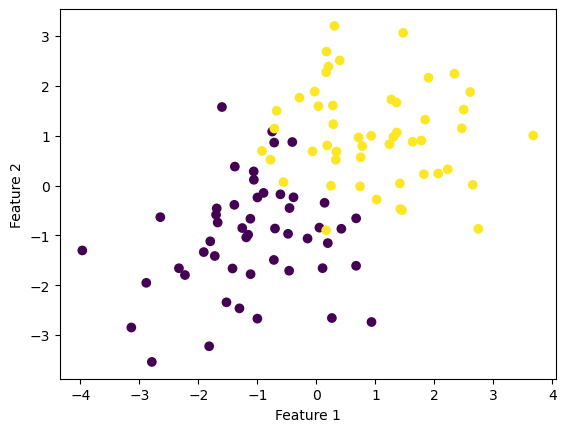

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from LogisticRegression import LogisticRegression
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
np.seterr(all='ignore')

p_features = 3

X, y = make_blobs(n_samples = 100, n_features = p_features - 1, centers = [(-1, -1), (1, 1)])
X_ = np.append(X, np.ones((X.shape[0], 1)), 1)

fig = plt.scatter(X[:,0], X[:,1], c = y)
xlab = plt.xlabel("Feature 1")
ylab = plt.ylabel("Feature 2")

### Regular Gradient Descent

We can fit a logistic regression model using regular gradient descent. This is a no frills approach – we are considering every point, calculating a new gradient for empirical risk based on the performance of the current weight vector, and, once empirical risk is minimized, the function is considered to be optimized.

In [8]:
LR = LogisticRegression()

LR.fit(X,y,alpha = 0.01,m_epochs = 10000)

converged


#### Now let's vizualize this...

In [14]:
w = LR.w

loss = LR.empirical_risk(X_, y, LR.loss, w)

fig, axarr = plt.subplots(1, 2)

axarr[0].scatter(X[:,0], X[:,1], c = y)
axarr[0].set(xlabel = "Feature 1", ylabel = "Feature 2", title = f"Loss = {loss}")

f1 = np.linspace(-3, 3, 101)

p = axarr[0].plot(f1, (w[2] - f1*w[0])/w[1], color = "black")

axarr[1].plot(LR.loss_history)
axarr[1].set(xlabel = "Iteration number", ylabel = "Empirical Risk")
plt.tight_layout()

AttributeError: 'LogisticRegression' object has no attribute 'empirical_risk'

This function does pretty well! 14.7% empirical risk is a pretty good performance, and visually, the line fits what we might expect. We can see in the plot on the right that the loss moved rapidly to a good solution but took a while to fully minimize.

### Let's try stochastic gradient descent now

Stochastic descent is *like* regular gradient descent, but weight is updated for a subset of points at a time rather than for all points.

The batch_size argument denotes how large the subset of points used for weight updates is.

In [10]:
LR2 = LogisticRegression()

LR2.fit_stochastic(X,y,10000,alpha=0.01,batch_size = 20) 

converged


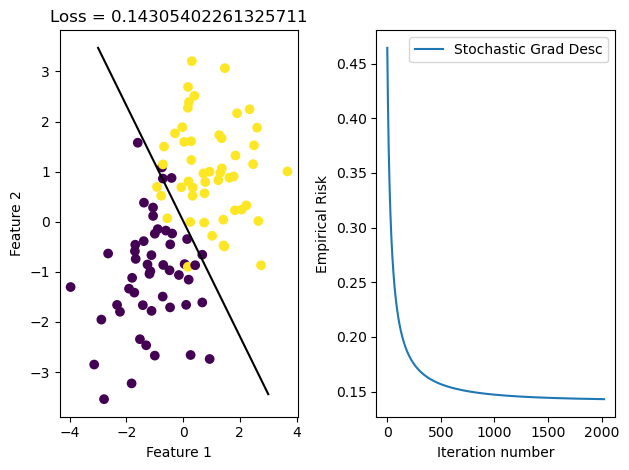

In [11]:
w2 = LR2.w

loss2 = LR2.loss(X_, y,w2)

fig, axarr = plt.subplots(1, 2)

axarr[0].scatter(X[:,0], X[:,1], c = y)
axarr[0].set(xlabel = "Feature 1", ylabel = "Feature 2", title = f"Loss = {loss2}")

f1 = np.linspace(-3, 3, 101)

p = axarr[0].plot(f1, (w2[2] - f1*w2[0])/w2[1], color = "black")

axarr[1].plot(LR2.loss_history)
axarr[1].set(xlabel = "Iteration number", ylabel = "Empirical Risk")
axarr[1].legend(["Stochastic Grad Desc"])
plt.tight_layout()

It worked as well! Actually, it worked even better than the regular gradient descent algorithm – the weights are very similar but stochastic gradient descent turns out just a slightly improved weight vector. I don't know if this is a bug in my code and if this is actually slightly better than what is achievable; clearly this is not an unreasonable weight vector but it is odd that it is consistently just a little bit better than the regular gradient descent method.

With that said, we can still see how quickly stochastic gradient descent works. It's important to note that each iteration here corresponds to an epoch, not to an individual weight update. There may be many weight updates in a single epoch. But by splitting points up into batches, we can ensure that each epoch really is a marked improvement over the one that came before.

### Relevance of Alpha

So far, we've worked with alpha = 0.01. This is a small but reasonable learning rate. But what if it's bigger?

In [13]:
LR.fit(X,y,alpha = 5,m_epochs = 10000)

converged


Converges with alpha = 5...

In [19]:
LR.fit(X,y,alpha = 100, m_epochs = 20000)

converged


Converges with alpha = 100, but we need many more epochs...

In [32]:
LR.fit(X,y,alpha = 10000, m_epochs = 100000)

Doesn't converge with alpha = 10,000 and 100,000 epochs.

Let's dive into the loss history of this iteration of the Logistic Regression fit method.

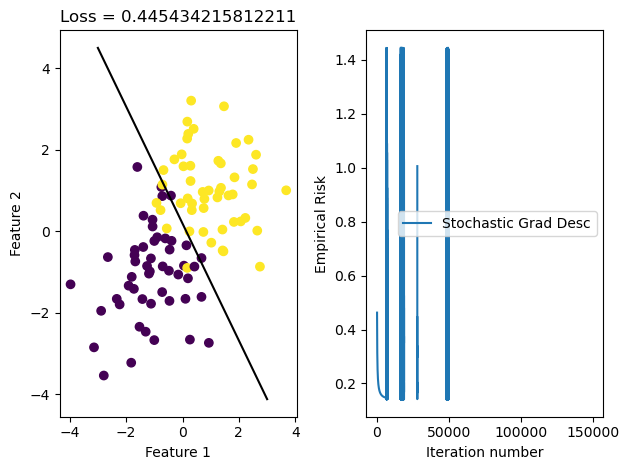

In [48]:
w3 = LR.w

fig, axarr = plt.subplots(1, 2)

axarr[0].scatter(X[:,0], X[:,1], c = y)
axarr[0].set(xlabel = "Feature 1", ylabel = "Feature 2", title = f"Loss = {loss3}")

f1 = np.linspace(-3, 3, 101)

p = axarr[0].plot(f1, (w3[2] - f1*w3[0])/w3[1], color = "black")

axarr[1].plot(LR.loss_history)
axarr[1].set(xlabel = "Iteration number", ylabel = "Empirical Risk")
axarr[1].legend(["Stochastic Grad Desc"])
plt.tight_layout()

That doesn't look good! It looks like we start out descending as we should, but then things look a little bit funky.

Let's dive into the loss history to see what happens here.

In [47]:
LR.loss_history[6000:7000:100]

[0.14742965239913441,
 0.147269892933168,
 0.14711595665205013,
 0.14202729291257218,
 0.1474466655245315,
 nan,
 nan,
 0.1740478913069895,
 nan,
 0.18211801679248396]

Here we go. At about the 500th iteration, we our value suddenly stops descending and starts to rise rapidly. This is because our learning rate is so large that we overshot the minimum of the function, and our gradient starts GROWING instead of minimizing.

### Relevance of batch size

How does batch_size influence the speed of the fit_stochastic method?

Let's explore this using a more complex set of points, with twelve feature dimensions.

In [111]:
p = 11

X1, y1 = make_blobs(n_samples = 100, n_features = p - 1,centers = 2)
X1_ = np.append(X, np.ones((X.shape[0], 1)), 1)

In [112]:
print(X1[0], X1.shape)

[ 2.31724415 -6.12119258 -6.56044559  5.94031272 -6.62189465 -0.6047373
 -1.65291106 -6.4506718   7.16439231  9.82855518] (100, 10)


Okay, now we have 100 different points with 12 features each. Let's try our algorithm on this set of points.

In [121]:
LR3 = LogisticRegression()

LR3.fit_stochastic(X1,y1,alpha = 0.001, m_epochs = 20000, batch_size = 50)
# Since batch size is 10, that means there will be ten batches in each epoch (100 points / batch size 10 = 10 batches)

converged


It converged! In how many steps?

In [122]:
len(LR3.loss_history)

10046

Let's try divvying the batches more. With a batch size of 50 and 100 points, there are only 2 batches per epoch.

In [123]:
LR3.fit_stochastic(X1,y1,alpha = 0.001, m_epochs = 20000, batch_size = 25)

converged


In [124]:
len(LR3.loss_history)

17562

Took longer than before.

In [125]:
LR3.fit_stochastic(X1,y1,alpha = 0.001, m_epochs = 20000, batch_size = 10)

converged


In [126]:
len(LR3.loss_history)

22708

Starting to see a pretty clear pattern.

In [127]:
LR3.fit_stochastic(X1,y1,alpha = 0.001, m_epochs = 20000, batch_size = 5)

converged


In [128]:
len(LR3.loss_history)

26346

It is pretty clear after running these experiments that decreasing the batch size INCREASES the amount of time it takes to converge to a true solution. This may be because smaller batches make more room for volatility (the weight might move in the wrong direction) so even though the loss might reach a reasonable point quickly, it takes a while to truly converge.

## Conclusion

Both the regular gradient descent and stochastic gradient descent are exciting and powerful. They do what the perceptron algorithm cannot, and find the best line if two sets of points are not linearly separable. They run on multiple dimensions, and are quite efficient even if not perfect. Given more time I would have loved to implement stochastic gradient with momentum, but didn't quite have the time to make it even more efficient. Something for the future.